# **0. Introduzione**

Data una serie di punti iniziali campionati da una funzione *black-box*, vogliamo costruire una rete neurale che faccia da *modello surrogato* utilizzabile successivamente per trovare l'ottimo di tale funzione sfruttando *Empirical Model Learning*.

Di solito, in un problema di regressione una rete neurale impara direttamente a predire il **target**. In altre parole, l'output $f(x_i)$ della rete è il **valore atteso** $E[x_i]$ di una distribuzione $D_i(\theta)$ che in questo caso varrà $f(x_i)$ quando $x = x_i$ e $0$ in tutti gli altri punti dello spazio dei target. È importante notare che $D_i(y)$ rappresenta una distribuzione univariata rispetto ai target, ovvero la possibile distribuzione dei target **fissato $x = x_i$** (i.e., in un grafico bidimensionale, una distribuzione lungo l'asse delle ordinate). In questo senso, si potrebbe infatti vedere $D_i(y)$ come una distribuzione parziale, parte della più grande distribuzione multivariata $D$ e tale per cui $D_i(y) = D(y | x = x_i)$.

Nel nostro problema, tuttavia, questo non è sufficiente. Oltre al valore atteso $E[x_i]$ (o $\mu_i$) vogliamo anche un intervallo di confidenza quantificato dalla deviazione standard $\sigma_i$, in modo da poter esplorare le aree più promettenti attraverso una certa funzione di acquisizione (e.g.,  Upper Confidence Interval, Probability of Improvement, Expected Improvement, Thompson Sampling, ...). Per questo possiamo usare `tensorflow_probability`, attraverso il quale possiamo impostare una certa distribuzione $D_i$ in modo che in ogni punto $x_i$ del nostro input si possa imparare l'intera distribuzione, così da avere non solo il valore atteso ma anche l'intervallo di confidenza, ed eventualmente fare sampling su quella distribuzione. 

In mancanza di altre assunzioni, scelgiamo $D_i \sim \mathcal{N}(\mu, \sigma^2)$, dove appunto $\mu_i = E[x_i]$ sarà il nostro valore atteso e $\sigma_i^2$ rappresenta la varianza dei possibili target nel punto $x_i$. In questo caso, la rete impara quindi una funzione continua $\mu(x)$, analoga alla precedente $f(x)$, parallelamente a un'altra funzione continua, $\sigma(x)$. Tuttavia, dal momento che il nostro processo è deterministico, la rete non ha alcun incentivo ad aumentare $\sigma(x)$, ma si focalizzerà al contrario su $\mu(x)$, come farebbe una normale rete neurale senza distribuzioni. Il nostro scopo è quindi quello di aumentare "artificialmente" il valore di $\sigma(x)$ nei punti poco campionati dello spazio **degli input**.

### ***0.1. Dataset***

Come prima cosa, definiamo la nostra funzione *black-box*, ovvero la [funzione di Ackley](https://www.sfu.ca/~ssurjano/ackley.html) con dimensionalità unaria per semplicità di visualizzazione. I punti iniziali ($4$) vengono camptionati in maniera equispaziata all'interno del dominio dell'input ($[-30, 30]$).

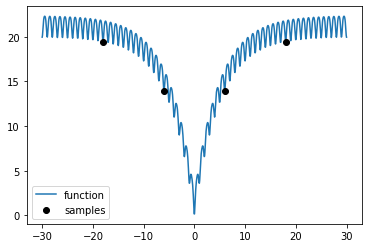

In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def seed(s = 0):
  random.seed(s)
  np.random.seed(s)
  tf.random.set_seed(s)

def fn(v, a = 20, b = 0.2, c = 2 * np.pi):
  # 1D Ackley
  term1 = -a * np.exp(-b * np.abs(v))
  term2 = -np.exp(np.cos(c * v))
  return term1 + term2 + a + np.e

num = 4
span = 30
space = 1000
hidden = [8, 8]

x = np.linspace(-span, span, num=num + 2, endpoint=True)[1:-1]
s = np.linspace(-span, span, num=space, endpoint=True)
y = fn(x)

plt.plot(s, fn(s), zorder=0, label='function')
plt.scatter(x, y, color='black', zorder=2, label='samples')
plt.legend()
plt.show()

# **1. Sampling Uniforme Simbolico**

Un modo per aumentare la varianza nei punti poco campionati dello spazio è quello di generare dei nuovi campioni $x_j$ in modo da coprire l'intero spazio e, per ognuno di questi, andare a generare **molti** target $y_{jk}$ secondo una distribuzione $P(y)$. Il campionamento dell'input non è di per sé troppo costoso, ma andando ad aggiungere i molteplici target la scalabilità diventa un grosso problema, senza contare che in principio vorremmo un campionamento perfetto sulla distribuzione $P(y)$ dei target, cosa possibile soltanto a fronte di un infinito numero di campioni.

Possiamo però risolvere questo problema attraverso delle computazioni simboliche. Fissiamo un certo $x_j$ nello spazio degli input e ammettiamo di campionare $n$ target $y_{jk}$ da $P(y)$, la loss per quel punto $x_j$ dell'input sarà data da:
$$\sum NLL(y_{ik}; \mu, \sigma) \cdot p(y_{ik})$$
dove $p(y_{ik})$ è la probabilità di campionamento di $y_{ik}$ data dalla distribuzione di campionamento $P(y)$ scelta (i.e., *la prior distribution*), e 
$$NLL(y_{ik}) = -log(\frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{1}{2}(\frac{y_{ik} - \mu}{\sigma})^2}) = \frac{1}{2}log(2\pi) + \frac{1}{2}(\frac{y_{ik} - \mu}{\sigma})^2 + log(\sigma^2)$$
è la negative log-likelihood della distribuzione normale.

Quando $n \rightarrow +\infty$, la sommatoria diventa un integrale, e quindi:
$$\int_{-\infty}^{+\infty} NLL(y_{ik}) \cdot p(y_{ik}) dy_{ik} = \int_{-\infty}^{+\infty} (\frac{1}{2}log(2\pi) + \frac{1}{2}(\frac{y_{ik} - \mu}{\sigma})^2 + log(\sigma^2)) \cdot p(y_{ik}) dy_{ik}$$

Generalmente, questo integrale può essere risolto in maniera simbolica una volta definita la *probability density function* $p(y)$, e quindi incorporato nella loss function della rete neurale. In particolare, quando non è presente nessuna prior knowledge, si utilizza la distribuzione uniforme $P(y) \sim \mathcal{U}(a, b)$, da cui deriva il seguente integrale:
$$\frac{1}{b-a} \int_a^b (\frac{1}{2}log(2\pi) + \frac{1}{2}(\frac{y_{ik} - \mu}{\sigma})^2 + log(\sigma^2)) dy_{ik}$$
il cui valore è:
$$\frac{a^2 + a b + b^2}{6 \sigma^2} + \mu \frac{\mu - a - b}{2 \sigma^2} + \frac{log(2\pi)}{2} + 2 \cdot log(\sigma)$$

### ***1.1. Data Augmentation***

Come già spiegato, questo metodo permette di evitare il sampling lungo lo spazio dei target ma no quello lungo lo spazio degli input. Il primo step è quindi quello di campionare in maniera uniforme lo spazio degli input, andando ad associare un'etichetta nulla (*nan*) nel caso dei nuovi campioni. 

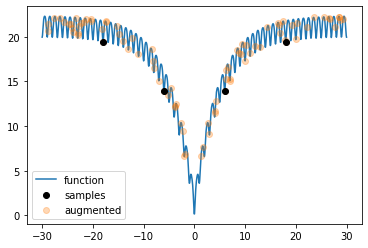

In [2]:
seed(0)

x_aug = np.random.uniform(-span, span, size=20 * num)
x_aug = np.concatenate((x, x_aug))
y_aug = np.concatenate((y, [np.nan] * (20 * num)))

plt.plot(s, fn(s), zorder=0, label='function')
plt.scatter(x, y, color='black', zorder=2, label='samples')
plt.scatter(x_aug, fn(x_aug), alpha=0.3, color='tab:orange', zorder=1, label='augmented')
plt.legend()
plt.show()

### ***1.2. Modello Surrogato***

A questo punto è possibile creare e allenare il modello surrogato attraverso la loss function personalizzata. Il modello è una rete neurale che ritorna in output due valori: il primo rappresenta il valore atteso $\mu_i$ mentre il secondo il logaritmo della deviazione standard $log(\sigma_i)$.

> In questi casi si utilizza $log(\sigma_i)$ al posto di $\sigma_i$ per due motivi principali:
1. il logaritmo può assumere anche valore negativo, perciò è più semplice per la rete da imparare
2. potenzialmente, si potrebbe usare una activation function esponenziale, ma in questo caso richiederebbe un ulteriore lambda layer perché andrebbe applicata soltanto a uno dei due neuroni (quello della deviazione standard, appunto), e comunque il logaritmo è presente nella loss function perciò andrebbe ricalcolato successivamente

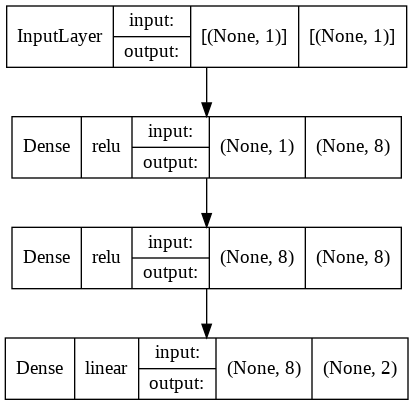

In [3]:
net = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(1,)),
  *[tf.keras.layers.Dense(h, activation='relu') for h in hidden],
  tf.keras.layers.Dense(2)
])

tf.keras.utils.plot_model(net, show_layer_names=False, show_layer_activations=True, show_shapes=True)

### ***1.3 Training con Custom Loss***

Il training è successivamente fatto utilizzando una loss personalizzata composta da due termini: (1) la negative log-likelihood, $NLL(x, y)$, rispetto ai target orignali, e (2) la loss apposita per il sampling, $\mathcal{L}_s(x)$, che è stata definita sopra. I due termini vengono bilanciati attraverso un fattore $\alpha$ tale per cui:
$$\mathcal{L}(x, y) = (1 - \alpha) \cdot NLL(x, y) + \alpha \cdot \mathcal{L}_s(x)$$

> La negative log-likelihood è stata implementata da zero al posto di usare le primitive di `tensorflow_probability` perché, attraverso quest'ultimo, non è possibile effettuare il masking dei campioni ottenuto tramite data augmentation, pertanto la likelihood risulterebbe *nan*.

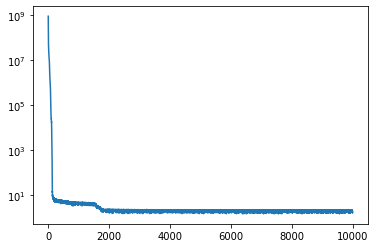

In [4]:
seed(0)
a = y.min()
b = y.max()
alpha = 0.5

def custom_loss(y_true, y_pred):
  # retrieve parameters
  mu = y_pred[:, :1]
  log_sigma = y_pred[:, 1:]
  sigma = tf.math.exp(log_sigma)
  sq_sigma = tf.math.square(sigma)
  # sampling loss computed on all the samples in order to increase the covariance
  sampling_loss = (a**2 + a*b + b**2) / (6. * sq_sigma) + mu * (mu - a - b) / (2. * sq_sigma) + 0.5 * tf.math.log(2. * np.pi) + 2. * log_sigma
  sampling_loss = tf.reduce_mean(sampling_loss)
  # input masking based on nan values
  mask = tf.logical_not(tf.math.is_nan(y_true))
  y_true = tf.boolean_mask(y_true, mask)
  mu = tf.boolean_mask(mu, mask)
  log_sigma = tf.boolean_mask(log_sigma, mask)
  sigma = tf.boolean_mask(sigma, mask)
  sq_sigma = tf.boolean_mask(sq_sigma, mask)
  # negative log-likelihood computed on the original samples only in order to compute the correct expected value
  log_likelihood = 0.5 * tf.math.squared_difference(y_true / sigma, mu / sigma) + 0.5 * tf.math.log(2. * np.pi) + log_sigma
  log_likelihood = tf.cond(tf.reduce_any(mask), lambda: tf.reduce_mean(log_likelihood), lambda: 0.0)
  # final loss built as a weighted sum of the two terms
  return (1 - alpha) * log_likelihood + alpha * sampling_loss


net.compile(optimizer='adam', loss=custom_loss)
history = net.fit(x_aug, y_aug, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

### ***1.4. Osservazioni Finali***

Il metodo in principio funziona come previsto, ovvero va ad aumentare l'intervallo di confidenza. I problemi principali di questo approccio, però, sono due:
1. senza un'indicazione esterna, l'intervallo di confidenza viene ampliato uniformemente in tutto l'input, rendendo di fatto il metodo inutile
2. non è chiaro quanto e come il parametro $\alpha$ influisca nella soluzione, ma in generale ogni parametro aggiuntivo rischia di complicare le cose e/o richiedere del tuning manuale

Una soluzione potrebbe essere quella di definire l'intervallo $[a, b]$ in maniera dinamica tramite una funzione $f(x) \rightarrow (a, b)$ e incorporare questi intervalli dinamici nella loss function. In questo modo, ad esempio, si potrebbe definire $f(x) \rightarrow (y, y)$ per tutti i campioni iniziali $x$ in modo che in quei punti la deviazione standard sia nulla, mentre nei punti restanti la funzione potrebbe assumere valore $f(x) \rightarrow (y_i - d(x, x_i), y_i + d(x, x_i))$, dove $x_i$ è il punto più vicino a $x$ fra i campioni iniziali e $d$ una metrica di distanza qualsiasi.

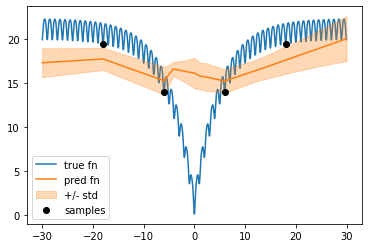

In [5]:
pred = net.predict(s)
mu = pred[:, 0].flatten()
sigma = np.exp(pred[:, 1]).flatten()

plt.plot(s, fn(s), zorder=0, label='true fn')
plt.plot(s, mu, color='tab:orange', zorder=1, label='pred fn')
plt.fill_between(s, mu-sigma, mu+sigma, alpha=0.3, color='tab:orange', zorder=2, label='+/- std')
plt.scatter(x, y, color='black', zorder=3, label='samples')
plt.legend()
plt.show()

# **2. Raffinamento Esplicito della Deviazione Standard**

Dal momento che la deviazione standard non viene calcolata esplicitamente dal modello, un'idea potrebbe essere quella di decidere arbitrariamente il valore di quest'ultima in ogni punto dello spazio. Ad esempio, data una funzione di distanza $d(x', x)$ potremmo dire che $\sigma = min \{d(x', x) \}$ con $x \in X_{tr}$, ovvero la deviazione standard per ogni punto $x'$ dello spazio dell'input è uguale alla distanza di $x'$ dal punto più vicino fra quelli campionati. Questa tecnica cerca di emulare infatti il calcolo della deviazione standard nei Processi Gaussiani, in cui appunto la confidenza diminuisce all'allontanarsi dai punti campionati.

A questo punto, invece che incorporare questa definizione dentro al modello di ottimizzazione di *EML*, rendendo la ricerca pesante, possiamo procedere attraverso due step sequenziali. Inizialmente, alleniamo la rete come in un normale problema di regressione, ovvero minimizzando l'errore quadratico medio rispetto ai target originali, senza quindi alcun tipo di data augmentation. A questo punto, fissiamo i pesi della rete riguardanti il task di regressione, ovvero la funzione $\mu(x)$, e andiamo a introdurre dei nuovi pesi utili a definire l'andamento della funzione $\sigma(x)$, allenata in modo da minimizzare l'errore quadratico medio rispetto alla funzione $d(x)$ non soltanto sui dati originali ma anche su un insieme di dati aumentati.

### ***2.1. Modello Surrogato***

Il modello surrogato in questo caso è una semplice rete neurale con un solo layer in output, che definisce appunto la funzione $\mu(x)$.

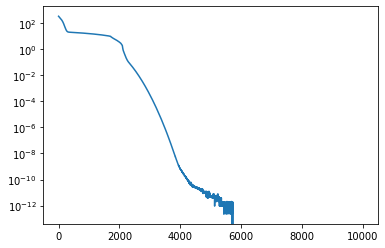

In [6]:
seed(0)

net = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(1,)),
  *[tf.keras.layers.Dense(h, activation='relu') for h in hidden],
  tf.keras.layers.Dense(1)
])

net.compile(optimizer='adam', loss='mse')
history = net.fit(x, y, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

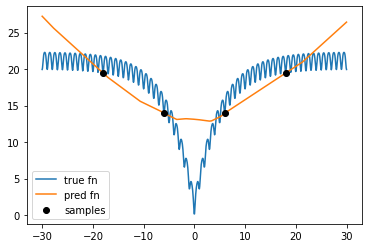

In [7]:
mu = net.predict(s).flatten()

plt.plot(s, fn(s), zorder=0, label='true fn')
plt.plot(s, mu, color='tab:orange', zorder=1, label='pred fn')
plt.scatter(x, y, color='black', zorder=3, label='samples')
plt.legend()
plt.show()

In [8]:
# # CUSTOM PLOT FOR PHD PRESENTATION

# def abs_distance(samples, references):
#   samples = np.repeat(samples.reshape((-1, 1)), len(references), axis=1)
#   distances = np.log(np.abs(samples - references) + 1)
#   return distances.min(axis=1)

# x_aug = np.linspace(-span, span, num=100 * num, endpoint=True)
# x_aug = np.concatenate((x, x_aug), axis=0)
# x_aug = np.sort(x_aug)

# y_std = abs_distance(x_aug, x)
# y_aug = net.predict(x_aug).flatten()

# best = np.argmin(y_aug - y_std)
# mu = net.predict(s).flatten()

# plt.figure(figsize=(7, 3))
# plt.plot(s, fn(s), zorder=2, label='true fn')
# plt.plot(s, mu, color='tab:orange', zorder=1, label='surr fn')
# plt.fill_between(x_aug, y_aug - y_std, y_aug + y_std, alpha=0.2, color='tab:orange', zorder=1, label='+/- std')
# plt.plot(x_aug, y_aug - y_std, color='black', zorder=0, label='acq fn')
# plt.scatter(x, y, color='black', zorder=3, label='samples')
# plt.scatter(x_aug[best], y_aug[best] - y_std[best], color='red', zorder=3, label='optimum')
# plt.legend()
# plt.savefig('blackbox.png')

### ***2.2. Calcolo della Deviazione Standard***

È quindi adesso necessario andare a campionare in maniera equispaziata sull'input, e creare il dataset aumentato a partire da questi campioni e quelli originali. Il target, in questo caso, non è più il valore atteso $\mu(x)$, di cui tra l'altro non abbiamo accesso per i dati aumentati, ma la deviazione standard $\sigma(x)$, che viene calcolata attraverso la funzione di distanza $d(x', x)$ specificata dall'utente.

Nell'esempio successivo, la funzione $\sigma(x)$ è codificata prima come valore assoluto della distanza dal punto campionato più vicino $x$. Ad ogni modo, è possibile anche definire la deviazione standard allo stesso modo di come questa viene [calcolata nei processi gaussiani](https://stats.stackexchange.com/questions/330185/how-to-calculate-the-standard-deviation-for-a-gaussian-process), lasciando quindi l'utente libero di scegliere il kernel più appropriato.

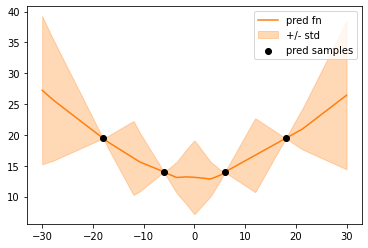

In [9]:
def abs_distance(samples, references):
  samples = np.repeat(samples.reshape((-1, 1)), len(references), axis=1)
  distances = np.abs(samples - references)
  return distances.min(axis=1)

x_aug = np.linspace(-span, span, num=100 * num, endpoint=True)
x_aug = np.concatenate((x, x_aug), axis=0)
x_aug = np.sort(x_aug)

y_std = abs_distance(x_aug, x)
y_aug = net.predict(x_aug).flatten()

plt.plot(x_aug, y_aug, color='tab:orange', zorder=0, label='pred fn')
plt.fill_between(x_aug, y_aug - y_std, y_aug + y_std, alpha=0.3, color='tab:orange', zorder=1, label='+/- std')
plt.scatter(x, net.predict(x).flatten(), color='black', zorder=2, label='pred samples')
plt.legend()
plt.show()

### ***2.3. Training Esplicito della Deviazione Standard***

A questo punto, è il momento di creare la nuova rete che andrà a definire la funzione $\sigma(x)$ a partire dalla rete precedente. Tenendo a mente che *EML* supporta soltanto le reti definite tramite *Sequential API*, la limitazione che abbiamo è quella di fissare tutti i layer precedenti all'ultimo.

> Nonostante andiamo a creare una nuova rete, infatti, possiamo ricreare una rete sequenziale a patto di fissare i pesi di tutti i layer precedenti. Infatti, data la rete originale $\mu(x) = [L_1, ..., L_k, L_{\mu}]$ e la nuova rete $\sigma(x) = [L_1, ..., L_k, L_{\sigma}]$, possiamo definire una rete finale $net(x) = [L_1, ..., L_k, L']$, dove $L'$ è un layer denso con due output i cui pesi possono essere ottenuti concatenando i pesi di $L_{\mu}$ e quelli di $L_{\sigma}$.
> 
> Potenzialmente, questo approccio potrebbe essere esteso anche ai layer precedenti, ad esempio creando da zero una rete apposita per $\sigma(x)$. Questo però richiederebbe più attenzione nella concatenazione dei pesi, in quanto tutti i pesi delle connessioni fra un neurone relativo a $\mu(x)$ e uno relativo a $\sigma(x)$, e viceversa, dovrebbero essere settati a zero in modo da non avere interferenza fra le due, risultanto tuttavia in una rete ugualmente espressiva ma molto più pesante della somma delle due Alternativamente, si potrebbe pensare di embeddare le due reti in *EML* separatamente, con il rischio però che la scalabilità degeneri molto presto.

Come prima cosa, quindi, impostiamo i pesi della rete $\mu(x)$ come non modificabili, e poi aggiungiamo un ultimo layer per calcolare $\sigma(x)$, questa volta aggiungendo anche l'attivazione esponenziale dal momento che la funzione di loss sarà semplicemente l'errore quadratico medio. 

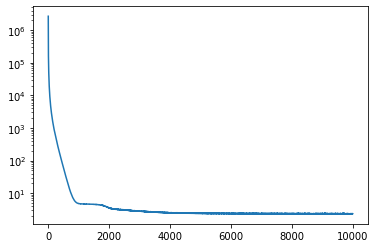

In [10]:
seed(0)

net.trainable = False
net_std = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,)),
    *net.layers[:-1],
    tf.keras.layers.Dense(1, activation='exponential')
])

net_std.compile(optimizer='adam', loss='mse')
history = net_std.fit(x_aug, y_std, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

### ***2.4. Osservazioni Finali***

La rete è in grado di imparare discretamente bene i trend della funzione $\sigma(x)$. Tuttavia, per come è definita, la deviazione standard è una funzione *piecewise-linear*, per cui la rete neurale tenderà ad appiattirne un po' il valore nei punti non differenziabili, rendendo quindi la funzione in uscita meno efficace della formulazione esplicita incorporata nel problema di ottimizzazione.

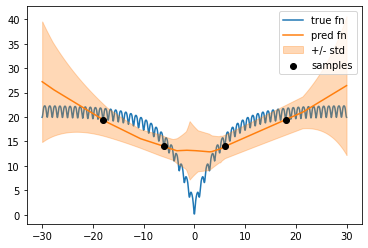

In [11]:
mu = net.predict(s).flatten()
sigma = net_std.predict(s).flatten()

plt.plot(s, fn(s), zorder=0, label='true fn')
plt.plot(s, mu, color='tab:orange', zorder=1, label='pred fn')
plt.fill_between(s, mu-sigma, mu+sigma, alpha=0.3, color='tab:orange', zorder=2, label='+/- std')
plt.scatter(x, y, color='black', zorder=3, label='samples')
plt.legend()
plt.show()

# **3. Surrogato della Funzione di Acquisizione**

Una volta ottenuti $\mu(x)$ e $\sigma(x)$, questi verranno utilizzati per ottimizzare una certa funzione di acquisizione (e.g., Upper Confidence Interval, Probability of Improvement, Expected Improvement, Thompson Sampling, ...).

C'è tuttavia da notare che, generalmente, le funzioni di acquisizione sono definite come $argmax \{ f(\mu, \sigma) \}$, dove $f(\mu, \sigma)$ ha una definizione esplicita e facilmente calcolabile, per cui si potrebbe usare la stessa pipeline precedente, con la differenza che, una volta allenata la rete $\mu(x)$, invece di aggiungere una nuova componenete per calcolare anche $\sigma(x)$ si va ad allenare una nuova rete $f(x)$ che simula direttamente il comportamento della funzione di acquisizione. Tale funzione ha il vantaggio di essere un modello a se stante (e quindi parametrizzabile a piacere), oltre che di avere in output una sola uscita, andando quindi a semplificare ulteriormente il processo di ottimizzazione tramite *EML*.

### ***3.1. Upper Confidence Interval***

Senza bisogno di creare una nuova, possiamo utilizzare la rete allenata nella sezione **2.1.** come modello surrogato per $\mu(x)$. Allo stesso modo, la funzione $\sigma(x)$ verrà definita esplicitamente sui dati aumentati della sezione **2.2.**

Una volta ottenute le due componenti, quindi, scegliamo una funzione di acquisizione e andiamo a calcolarne il valore. Per semplicità si mostra il caso dell'*Upper Confidence Interval*, in cui: $f(x) = \mu(x) + \lambda \cdot \sigma(x)$, dove $\lambda$ è un iperparametro che definisce il livello di esplorazione.
> In realtà, dal momento che stiamo cercando il minimo della funzione *black-box*, la funzione di acquisizione sarà $f(x) = \mu(x) - \lambda \cdot \sigma(x)$.   

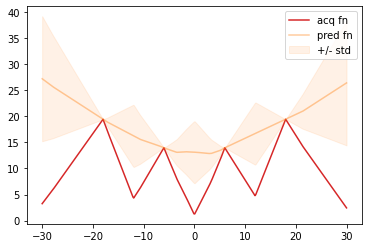

In [12]:
lam = 2.0
acq_fn = y_aug - lam * y_std

plt.plot(x_aug, acq_fn, color='tab:red', zorder=0, label='acq fn')
plt.plot(x_aug, y_aug, color='tab:orange', alpha=0.4, zorder=1, label='pred fn')
plt.fill_between(x_aug, y_aug - y_std, y_aug + y_std, alpha=0.1, color='tab:orange', zorder=2, label='+/- std')
plt.legend()
plt.show()

### ***3.2. Funzione di Acquisizione Surrogata***

L'ultimo passo è quindi quello di allenare una **nuova** rete neurale che approssimi direttamente la funzione di acquisizione $f(x)$. Il problema è un semplice task di regressione, per cui è possibile usare come funzione di loss l'errore quadratico medio.

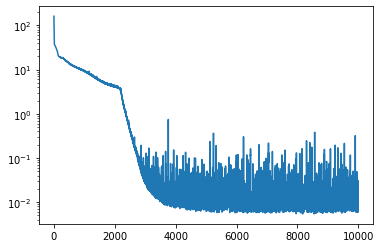

In [13]:
seed(0)

net = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(1,)),
  *[tf.keras.layers.Dense(h, activation='relu') for h in hidden],
  tf.keras.layers.Dense(1)
])

net.compile(optimizer='adam', loss='mse')
history = net.fit(x_aug, acq_fn, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

### ***3.3. Osservazioni Finali***

La rete è in grado di imparare molto bene i trend della funzione di acquisizione nonostante anche questa sia *piecewise-linear*, questo perché mentre la funzione $\sigma(x)$ di prima aveva a disposizione un unico layer da allenare, in questo caso il modello viene allenato da zero e quindi può utilizzare entrambi i layer a piacere, cosa che permette di avere un'alta accuratezza anche nei punti non dif

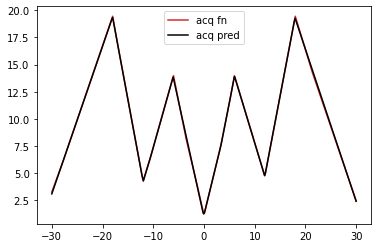

In [14]:
plt.plot(x_aug, acq_fn, color='tab:red', zorder=0, label='acq fn')
plt.plot(x_aug, net.predict(x_aug), color='black', zorder=1, label='acq pred')
plt.legend()
plt.show()